#### Aim:
To build Neural Style Transfer Model using Keras

#### Steps:

1. Load VGG19 model from keras
2. Load images
3. Define the content and style layers
4. Get outputs corresponding to style and content layers
5. Build model
6. Extract content and style features
7. Content Loss
8. Style Loss
9. Total Loss
10. Calculate Gradients
11. Style Transfer
12. Deprocess image


### Images

In [1]:
!wget ./ https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
!wget ./ https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [0]:
content_image_path = "./Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg"
style_image_path = "./Vassily_Kandinsky,_1913_-_Composition_7.jpg"

In [0]:
import tensorflow as tf

In [0]:
tf.enable_eager_execution()

In [0]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np

Using TensorFlow backend.


### Load VGG19 model from keras

In [0]:
from keras.applications import vgg19
from keras import backend as K

In [0]:
vgg_model = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
vgg_model.trainable = False
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Load image

In [0]:
content_image_path = "./Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg"
style_image_path = "./Vassily_Kandinsky,_1913_-_Composition_7.jpg"

In [0]:
def resize_image(img_file):
    
    #Max image dimension
    max_img_side = 400
    
    #Load image
    img = load_img(img_file)
    
    #Get size
    w, h = img.size
    bigger_side_size = max(img.size)
    
    #Scale to use
    scale = max_img_side/bigger_side_size
    
    #Resize image
    img = img.resize((round(w*scale),round(h*scale)))    
    
    return img

In [0]:
def preprocess_image(image_path):
    img = resize_image(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [0]:
content_image = K.variable(preprocess_image(content_image_path))
style_image = K.variable(preprocess_image(style_image_path))

### Define the content and style layers

In [0]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

###  Get outputs corresponding to style and content layers 


In [0]:
style_outputs = [vgg_model.get_layer(name).output for name in style_layers]
content_outputs = [vgg_model.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs

### Build model

In [0]:
model = tf.keras.models.Model(inputs=vgg_model.input, outputs=model_outputs)

### Extract content and style features

In [0]:
#Get outputs
content_outputs = model(content_image)
style_outputs = model(style_image)


#Get Style and content features
style_features = [op[0] for op in style_outputs[:len(style_layers)]]
content_features = [op[0] for op in content_outputs[len(style_layers):]]

### Content Loss

In [0]:
def content_loss(actual, prediction):
    
    c_loss = tf.reduce_mean(tf.square(actual - prediction))
    
    return c_loss

### Style Loss

In [0]:
#Calculate Gram Matrix
def gram_matrix(layer_op):
    
    depth = int(layer_op.shape[-1])
    a = tf.reshape(layer_op, [-1, depth])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    
    return gram/tf.cast(n, tf.float32)

  
def style_loss(actual, prediction):
    
    gram_actual = gram_matrix(actual)
    gram_prediction = gram_matrix(prediction)
    
    return tf.reduce_mean(tf.square(gram_actual - gram_prediction))

### Total Loss

In [0]:
def total_loss(new_img, actual_style_features, actual_content_features, loss_weights):
    
    #Get model output for new_img
    model_op = model(new_img)
    
    #Get features
    new_style_features = model_op[:len(style_layers)]
    new_content_features = model_op[len(style_layers):]
    
    #Initialize loss
    cur_style_loss = 0
    cur_content_loss = 0
    
    #Calculate Style loss for all layers
    for i in range(len(style_layers)):
        
        cur_style_loss += style_loss(actual_style_features[i], new_style_features[i])
        
    #Calculate Content loss
    for i in range(len(content_layers)):
        
        cur_content_loss += content_loss(actual_content_features[i], new_content_features[i])
        
    
    #Normalize loss for number of layers
    cur_style_loss = cur_style_loss / len(style_layers)
    cur_content_loss = cur_content_loss / len(content_layers)
    
    #Combine losses with weightage
    combined_loss = cur_style_loss*loss_weights[0] + cur_content_loss*loss_weights[1]
    
    return combined_loss, cur_style_loss, cur_content_loss

### Calculate Gradients

In [0]:
def calc_gradients(config_info):
    
    #Let tape record all operations to calculate loss
    with tf.GradientTape() as tape:
        loss = total_loss(**config_info)
    
    #Get the combined loss
    combined_loss = loss[0]
    
    #Calculate gradients
    grads = tape.gradient(combined_loss, config_info['new_img'])
    
    return grads, loss

### Style Transfer

In [0]:
import tensorflow.contrib.eager as tfe
import IPython.display

In [0]:
def style_transfer(content_file, style_file, content_features, style_features):
    
    #Get Style and Content features for Original image
    actual_style_features = style_features
    actual_content_features = content_features
    
    
    #Create new image fpr transformation, we will initialize it with content img
    new_img = preprocess_image(content_file)
    
    #Create a tf variable based on the image
    new_img = tfe.Variable(new_img, dtype=tf.float32)
    
    #Optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    
    #Config info
    config_info = {'new_img': new_img, 
                   'actual_style_features': actual_style_features, 
                   'actual_content_features': actual_content_features, 
                   'loss_weights':[1e-2, 1e3]} #Style weight, Content Weight
    
    #Track lowest loss and best new img
    lowest_loss = float('inf')
    best_img = None
    
    #Keep interim images
    generated_imgs = []
    
    #Clip Values
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means
    
    #Run training i.e updating the new img for some iterations
    for i in range(100):
        
        #Get gradients and all losses
        grads, losses = calc_gradients(config_info)
        
        #Get 3 losses
        combined_loss, style_loss, content_loss = losses
        
        #Apply Gradients
        optimizer.apply_gradients([(grads, new_img)])
        
        #Clip new_img
        clipped_img = tf.clip_by_value(new_img, min_vals, max_vals)        
        new_img.assign(clipped_img)
        
        if combined_loss < lowest_loss:
            
            lowest_loss = combined_loss
            best_img = deprocess_img(new_img.numpy())
            
        
        #Display new_img at regular interval
        if i % 10 == 0:
            
            plot_img = deprocess_img(new_img.numpy())
            generated_imgs.append(plot_img)
            
            IPython.display.clear_output(wait=True)
            
            plot_img =  tf.keras.preprocessing.image.array_to_img(plot_img)
            IPython.display.display_png(plot_img)
            
            print('Iteration:', i, 'Total loss', combined_loss.numpy(), '\n'
                  'Style loss:', style_loss.numpy(), '\n'
                  'Content loss:', content_loss.numpy())
            
    return lowest_loss, best_img, generated_imgs

### Convert back to original image representation

In [0]:
def deprocess_img(processed_img):
    
    #Create a copy of processed image
    dp_img = processed_img.copy()
    
    #Remove batch dimension i.e make it 3D from 4D
    dp_img = np.squeeze(dp_img, 0)
    
    #Add the means of VGG19
    dp_img[:,:,0] += 103.939
    dp_img[:,:,1] += 116.779
    dp_img[:,:,2] += 123.68
    
    #BGR to RGB
    dp_img = dp_img[:,:,::-1]
    
    dp_img = np.clip(dp_img, 0, 255)
    
    return dp_img

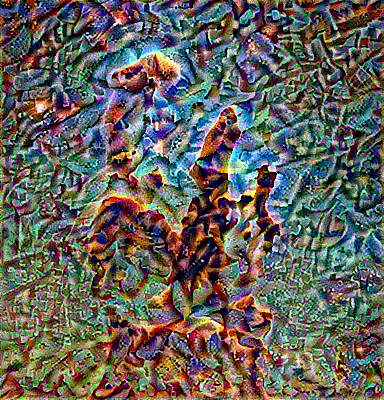

Iteration: 90 Total loss 25935412.0 
Style loss: 2229863000.0 
Content loss: 3636.7834


In [0]:
loss, best_img, generated_imgs = style_transfer(content_image_path,\
                                                style_image_path, \
                                                content_features, style_features)

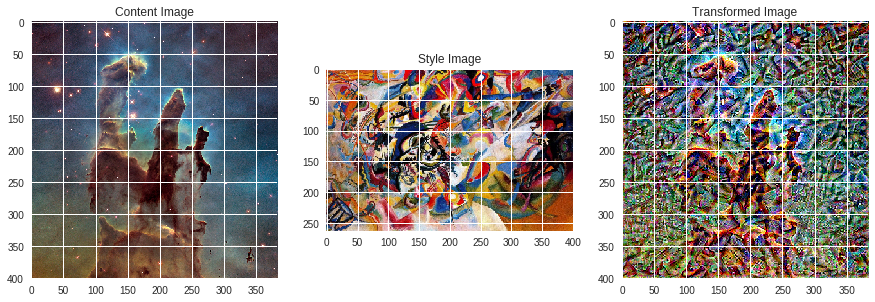

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))


#Display content image
plt.subplot(1,3,1)
plt.imshow(resize_image(content_image_path))
plt.title('Content Image')

#Display Style image
plt.subplot(1,3,2)
plt.imshow(resize_image(style_image_path))
plt.title('Style Image')

#Display Style image
plt.subplot(1,3,3)
plt.imshow(tf.keras.preprocessing.image.array_to_img(best_img))
plt.title('Transformed Image')

plt.show()